In [33]:
import numpy as np
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site('in2p3')
import healpy
import matplotlib.pyplot as plt
import glob, sys
import astropy.units as u
from astropy.io import fits as fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy
import clmm
import time
import pyccl as ccl
sys.path.append('../')
import _utils_extract_sources_in_cosmoDC2 
import _config_extract_sources_cosmoDC2
sys.path.append('../../lensing_profile_measurement')
import _config_lensing_profiles
import _utils_lensing_profiles
sys.path.append('../../')
import _redshift_richness_bins
#test
from astropy.table import QTable, Table, vstack, join, hstack
import pickle,sys

def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

from clmm import Cosmology
from scipy.integrate import simps
#connection with qserv
import mysql
from mysql.connector import Error
import argparse

In [4]:
path_to_data = '../../../CLCosmo_Sim_database/data_vary_fuducial_cosmology/'


H0_true = 71
h = H0_true/100
Omega_b_true = 0.02258 / (h**2)
Omega_c_true = 0.1109 / (h**2)
Omega_m_true = Omega_b_true + Omega_c_true
sigma8_true = 0.8
ns_true = 0.963

cosmo_clmm_fid_distance = Cosmology(H0 = H0_true, Omega_dm0 = Omega_c_true, Omega_b0 = Omega_b_true, Omega_k0 = 0.0)
cosmo_clmm_fid_distance.be_cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true,
                                        h = H0_true/100, sigma8 = sigma8_true, 
                                        n_s=ns_true, w0=-1, wa=0)

#select galaxy clusters
lens_catalog_name='../../../CLCosmo_Sim_database/data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl'
lens_catalog=np.load(lens_catalog_name, allow_pickle=True)
mask_select=(lens_catalog['richness'] > 20)*(lens_catalog['redshift'] > .2)*(lens_catalog['redshift'] <= 1)
lens_catalog=lens_catalog[mask_select]
lens_catalog_truncated=lens_catalog
use_only_member_galaxies = False

n_cl=len(lens_catalog_truncated)

#load source catalogs
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']

In [18]:
ra_list = np.random.random(50)*(np.max(lens_catalog['ra']) - np.min(lens_catalog['ra'])) + np.min(lens_catalog['ra'])
dec_list = np.random.random(50)*(np.max(lens_catalog['dec']) - np.min(lens_catalog['dec'])) + np.min(lens_catalog['dec'])

==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracti

/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/extract_DC2_data/extract_DC2_data_vary_fiducial_cosmology/../_utils_extract_sources_in_cosmoDC2.py:108: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tab = pd.read_sql_query(query_mysql, conn_qserv)


==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)
==> extracting true redshift + shapes infos (Qserv)


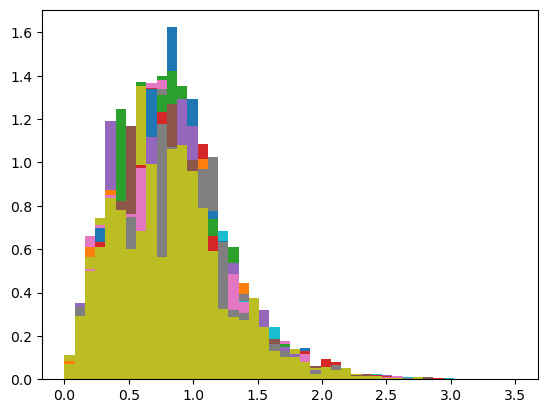

In [19]:
def qserv_query(lens_z, theta_max, ra, dec):
    r"""
    quantities wanted + cuts for qserv
    Attributes:
    -----------
    z: float
        lens redshift
    lens_distance: float
        distance to the cluster
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0.#zmin = lens_z + .05
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, data.halo_id as halo_id, "
    query += "data.mag_i, data.mag_r, data.mag_y, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true_uncorr, data.ellipticity_2_true as e2_true_uncorr " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 24.6 "
    query += f"AND data.mag_r <= 28.0 "
    query += ";" 
    return query

n = 0
histogram_list = []
for ra, dec in zip(ra_list, dec_list):

    z, ra, dec=0.4, ra, dec
    
    lens_distance = cosmo_clmm_fid_distance.eval_da(z)
    
    lens_z_bin_0 = _redshift_richness_bins.z_corner[_redshift_richness_bins.z_corner <= z][-1]
    lens_z_bin_1 = _redshift_richness_bins.z_corner[_redshift_richness_bins.z_corner >= z][0]
    lens_z_mid = (lens_z_bin_0 + lens_z_bin_1)/2
    
    lens_distance_z_bin_0=cosmo_clmm_fid_distance.eval_da(lens_z_bin_0)
    lens_distance_z_bin_1=cosmo_clmm_fid_distance.eval_da(lens_z_bin_1)
    lens_distance_z_mid=cosmo_clmm_fid_distance.eval_da(lens_z_mid)
    theta_max = (7/lens_distance_z_mid) * (180/np.pi)
    bin_edges_R = clmm.dataops.make_bins(0.5, 10, 15, method='evenlog10width')
    bin_edges = (bin_edges_R / lens_distance_z_mid) * (10800/np.pi)
    
    conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
    cursor = conn.cursor(dictionary=True, buffered=True)
    #extract background galaxies with qserv (only true photoz)
    print('==> extracting true redshift + shapes infos (Qserv)')
    dat_extract=_utils_extract_sources_in_cosmoDC2.extract(qserv_query = qserv_query(z, theta_max, ra, dec),
                                        conn_qserv=conn, cosmo=None)
    dat_extract_mag_cut = _config_extract_sources_cosmoDC2.source_selection_magnitude(dat_extract)
    if len(dat_extract)==0: continue

    if n == 0:
        
        dat_extract_base=dat_extract_mag_cut
    else: 
        dat_extract_base = vstack([dat_extract_base, dat_extract_mag_cut])
    bins=np.linspace(0, 3.5, 45)
    histogram, b, _ = plt.hist(dat_extract['z'], bins=bins, density=True)
    histogram_list.append(histogram)
    conn.close()

In [94]:
#save_pickle(histogram_list, 'histogram_list.pkl')
histogram_list = load('histogram_list.pkl')

In [95]:
bin_centers = (bins[:-1] + bins[1:]) / 2

In [118]:
nz_list = np.array([n/np.trapz(n,bin_centers) for n in histogram_list])
nz_mean = np.mean(nz_list, axis=0)
nz_mean =nz_mean/np.trapz(nz_mean, bin_centers)
nz_err = np.std(nz_list, axis=0)/np.sqrt(len(histogram_list))

In [132]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# --- Unnormalized model ---
def nz_chang2013_raw(z, alpha, beta, z0):
    return z**alpha * np.exp(-(z / z0)**beta)

# --- Normalized wrapper ---
z_grid = bin_centers
def nz_chang2013(z, alpha, beta, z0):
    # use a fixed z-grid for normalization
    y_grid = nz_chang2013_raw(z_grid, alpha, beta, z0)
    norm = np.trapz(y_grid, z_grid)
    return nz_chang2013_raw(z, alpha, beta, z0) / norm

# --- Fit ---
popt, pcov = curve_fit(
    nz_chang2013,
    bin_centers[(bin_centers >0.1)*(bin_centers < 2)],   # xdata
    nz_mean[(bin_centers >0.1)*(bin_centers < 2)],       # ydata
    sigma=nz_err[(bin_centers >0.1)*(bin_centers < 2)],
    absolute_sigma=True,
    p0=[1.2, 1.5, 0.5]
)

# --- Results ---
alpha_fit, beta_fit, z0_fit = popt
alpha_err, beta_err, z0_err = np.sqrt(np.diag(pcov))
print(f"alpha = {alpha_fit:.3f} ± {alpha_err:.3f}")
print(f"beta  = {beta_fit:.3f} ± {beta_err:.3f}")
print(f"z0    = {z0_fit:.3f} ± {z0_err:.3f}")

# --- Plot ---
z_fit = np.linspace(min(bin_centers), max(bin_centers), 300)
n_fit = nz_chang2013(z_fit, *popt)


alpha = 0.955 ± 0.020
beta  = 2.260 ± 0.047
z0    = 0.992 ± 0.017


Text(0, 0.5, 'distribution')

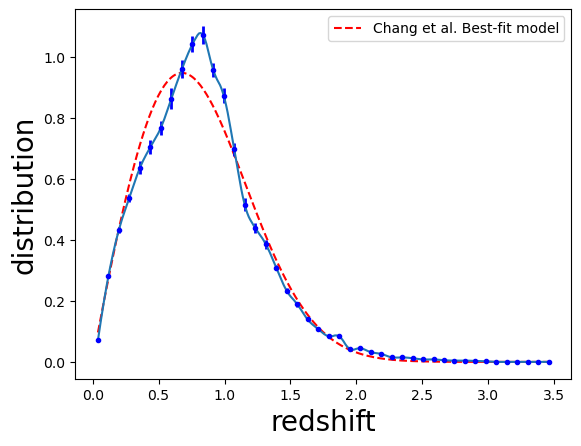

In [139]:
z_axis = np.linspace(0, 3.5, 100)
n = nz_chang2013(z_axis, *popt )
import scipy
interpf = scipy.interpolate.interp1d(bin_centers, nz_mean, kind='quadratic')
plt.plot(z_fit, n_fit, '--r', label='Chang et al. Best-fit model')
plt.errorbar(bin_centers, nz_mean,nz_err, fmt=' ', lw=2, marker='o', color='b', markersize=3)
plt.plot(z_fit, interpf(z_fit))
plt.xlabel('redshift', fontsize=20)
plt.legend()
plt.ylabel('distribution', fontsize=20)

In [123]:
nz = {}
nz['nz'] = nz_mean
nz['nz_err'] = nz_err
nz['z'] = bin_centers
save_pickle(nz, 'redshift_distribution_cosmoDC2_source_selection.pkl')